#### Problem 1: 
We are looking for ways to improve customer service for those who received an offer they did not like due to high interest rate.

#### Problem 2: 
Customers that are unhappy with their offer may lead to a bad customer experience if they do not know why they received the rate that they did. Bad customer experience may lead them to apply to other lenders if they are searching for a lower rate. We want to improve their experience so that they will want to re-apply with us in the future (whether it is a first time customer or a current customer looking to refinance their loan.

#### Problem 3: 
This is a competitive market where there are many lenders. We want to be able to maintain our share of the market.

#### Summary:
This project will look at variables correlated to loan interest rate. In order to improve customer experience for customers who received offers they did not like, due to high interest rate, we need to know what affects their interest rate. By knowing what affects their rate, we can have our sales rep advise our customers on areas they can improve on so that they can re-apply in the future for a lower rate if they choose to. We hope this would improve overall customer experience and may save time/money trying to aqcuire new customers. 

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\dhua\Desktop\Springboard\Lending Club Capstone 2\LC_2007_to_2018.csv", header = 0)
df.head()

C:\Users\dhua\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(2260701, 151)

#### For less confusion I am going to change the name of fico_range_low to just FICO
The data set has another column title fico_range_high, which is basically fico_range_low but 4 points higher. The range that is given tells us that the customer's actual FICO score is between the low and high range. We will be going with the lower range for our analysis, which was a random choice and I do not see how this would affect our regression model.

In [4]:
df.rename(columns={'fico_range_low':'FICO'}, inplace=True)

##  <font color=blue>Data Cleaning Part 1: Selecting variables and dealing with missing data</font>
 

#### Need to clean up the ID column first due to a string that is causing empty cells in several rows
There is a string "Total amount funded has policy code 1" and "Total amount funded in policy code 2" entered throughout that column. We will need to remove those rows so that there are no blank rows that will intefere with our analysis. The code below will show an example what the string looks like.

In [5]:
# Total amount funded has policy code 1 and Total amount funded in policy code 2 throughout the id column
df['id'] = df['id'].astype(str)
print(df.iloc[421095:421105,0:5].dtypes)
print(df.iloc[421095:421105,0:5])

id                  object
member_id          float64
loan_amnt          float64
funded_amnt        float64
funded_amnt_inv    float64
dtype: object
                                                      id  member_id  \
421095  Total amount funded in policy code 1: 6417608175        NaN   
421096  Total amount funded in policy code 2: 1944088810        NaN   
421097                                         130954621        NaN   
421098                                         130964697        NaN   
421099                                         130955326        NaN   
421100                                         130504052        NaN   
421101                                         130956066        NaN   
421102                                         130502727        NaN   
421103                                         130258413        NaN   
421104                                         129913276        NaN   

        loan_amnt  funded_amnt  funded_amnt_inv  
421095        NaN  

#### Remove all rows in the id column with the unwanted strings and we can check to see if it was done correctly

In [6]:
df = df[~df.id.str.contains("Total amount funded in policy code")]
print(df.iloc[421090:421105,0:3])

               id  member_id  loan_amnt
421090   36371250        NaN    10000.0
421091   36441262        NaN    24000.0
421092   36271333        NaN    13000.0
421093   36490806        NaN    12000.0
421094   36271262        NaN    20000.0
421097  130954621        NaN     5000.0
421098  130964697        NaN    15000.0
421099  130955326        NaN    11200.0
421100  130504052        NaN    25000.0
421101  130956066        NaN     3000.0
421102  130502727        NaN    17000.0
421103  130258413        NaN    20000.0
421104  129913276        NaN    19200.0
421105  130968790        NaN     6500.0
421106  130711441        NaN    10000.0


#### Reset the index in case we need to call on the index later in our analysis.
Notice how index 421095 and 421096 are missing from the output above

In [7]:
df.reset_index(inplace=True, drop=True)

#### Lets convert issue date to datetime. Issue date is when the loan was issued.
Will need to convert 'issue_d' to datetime and then format to month/year since all of the days starts on the 1st it will not matter to us

In [8]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

#### Lets work with more recent data since policies may have changed over the years. Will focus on 2016 - 2018

In [9]:
df_16to18 = df[df['issue_d']>"2015-12-31"]
df_16to18['issue_d'].describe()

count                 1373228
unique                     36
top       2016-03-01 00:00:00
freq                    61992
first     2016-01-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [10]:
df_16to18.shape

(1373228, 151)

#### Select variables to analyze. We do not need all of the variables since some of them will not help explain correlation. Instead of dropping columns I did not need, I found it easier to select the ones I think might be useful since there were over 150 columns

In [11]:
#This will be our filter to narrow down our dataset with only necessary variables that may help us with our analysis.
features = ['int_rate', 'loan_amnt', 'annual_inc', 'dti', 'FICO', 
            'inq_last_6mths','mths_since_last_delinq', 'mths_since_last_record',
            'open_acc','pub_rec','revol_bal','revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'mths_since_last_major_derog', 'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_12m',
            'open_il_24m', 'mths_since_rcnt_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'total_rev_hi_lim',
            'inq_last_12m', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
            'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
            'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
            'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_tl_120dpd_2m',
            'num_tl_30dpd', 'num_tl_90g_dpd_24m' , 'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 
            'total_bc_limit', 'total_il_high_credit_limit',
            'term', 'emp_title', 'emp_length', 'home_ownership', 'issue_d', 'purpose', 'addr_state',
            'application_type', 'disbursement_method','verification_status','grade']


loan_df = df_16to18[features]
print("Rows, Cols")
print(loan_df.shape)
print()
print(loan_df.info())

Rows, Cols
(1373228, 63)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373228 entries, 421095 to 2260668
Data columns (total 63 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   int_rate                        1373228 non-null  float64       
 1   loan_amnt                       1373228 non-null  float64       
 2   annual_inc                      1373228 non-null  float64       
 3   dti                             1371519 non-null  float64       
 4   FICO                            1373228 non-null  float64       
 5   inq_last_6mths                  1373227 non-null  float64       
 6   mths_since_last_delinq          669068 non-null   float64       
 7   mths_since_last_record          222092 non-null   float64       
 8   open_acc                        1373228 non-null  float64       
 9   pub_rec                         1373228 non-null  float64       
 10  revol_bal  

#### Lets look at the sum of missing data in two parts for easier visibility due to high number of columns
We need to decide how we will handle the missing variables

In [12]:
# Sum of data missing for each variable for first half of the data
print(loan_df.iloc[:,0:30].isnull().sum())

int_rate                             0
loan_amnt                            0
annual_inc                           0
dti                               1709
FICO                                 0
inq_last_6mths                       1
mths_since_last_delinq          704160
mths_since_last_record         1151136
open_acc                             0
pub_rec                              0
revol_bal                            0
revol_util                        1300
total_acc                            0
collections_12_mths_ex_med           0
mths_since_last_major_derog    1014176
acc_now_delinq                       0
open_acc_6m                         62
open_act_il                         61
open_il_12m                         61
open_il_24m                         61
mths_since_rcnt_il               43294
il_util                         200027
open_rv_12m                         61
open_rv_24m                         61
total_rev_hi_lim                     0
inq_last_12m             

#### Calculate percentage of data missing for each variable for first half of the data


In [13]:
missing_data1 = loan_df.iloc[:,0:30].isnull().sum()
length_data = len(loan_df)
missing_pct_data1 = (missing_data1/length_data).round(2)
print(missing_pct_data1.sort_values(ascending = False))

mths_since_last_record         0.84
mths_since_last_major_derog    0.74
mths_since_last_delinq         0.51
il_util                        0.15
mths_since_rcnt_il             0.03
mo_sin_old_il_acct             0.03
bc_util                        0.01
bc_open_to_buy                 0.01
open_rv_24m                    0.00
open_rv_12m                    0.00
loan_amnt                      0.00
annual_inc                     0.00
dti                            0.00
FICO                           0.00
inq_last_6mths                 0.00
open_acc                       0.00
pub_rec                        0.00
revol_bal                      0.00
revol_util                     0.00
total_acc                      0.00
collections_12_mths_ex_med     0.00
chargeoff_within_12_mths       0.00
acc_now_delinq                 0.00
open_acc_6m                    0.00
open_act_il                    0.00
open_il_12m                    0.00
open_il_24m                    0.00
inq_last_12m                

#### Calculate sum of data missing for each variable for second half of data

In [14]:
print(loan_df.iloc[:,30:65].isnull().sum())

mo_sin_old_rev_tl_op                    0
mo_sin_rcnt_tl                          0
mort_acc                                0
mths_since_recent_bc                16005
mths_since_recent_bc_dlq          1061159
mths_since_recent_inq              158741
mths_since_recent_revol_delinq     923819
num_accts_ever_120_pd                   0
num_actv_bc_tl                          0
num_actv_rev_tl                         0
num_bc_tl                               0
num_il_tl                               0
num_op_rev_tl                           0
num_rev_accts                           0
num_tl_120dpd_2m                    56035
num_tl_30dpd                            0
num_tl_90g_dpd_24m                      0
num_tl_op_past_12m                      0
percent_bc_gt_75                    17020
pub_rec_bankruptcies                    0
total_bc_limit                          0
total_il_high_credit_limit              0
term                                    0
emp_title                         

#### Calculate percentage of data missing for each variable for second half of the data

In [15]:
missing_data2 = loan_df.iloc[:,30:65].isnull().sum()
length_data = len(loan_df)
missing_pct_data2 = (missing_data2/length_data).round(2)
#filt_missing_pct = print(missing_pct[missing_pct<0.70])
print(missing_pct_data2.sort_values(ascending = False))

mths_since_recent_bc_dlq          0.77
mths_since_recent_revol_delinq    0.67
mths_since_recent_inq             0.12
emp_title                         0.08
emp_length                        0.07
num_tl_120dpd_2m                  0.04
mths_since_recent_bc              0.01
percent_bc_gt_75                  0.01
num_actv_rev_tl                   0.00
num_op_rev_tl                     0.00
num_il_tl                         0.00
num_bc_tl                         0.00
grade                             0.00
num_actv_bc_tl                    0.00
num_accts_ever_120_pd             0.00
mort_acc                          0.00
mo_sin_rcnt_tl                    0.00
num_rev_accts                     0.00
num_tl_90g_dpd_24m                0.00
num_tl_30dpd                      0.00
verification_status               0.00
num_tl_op_past_12m                0.00
pub_rec_bankruptcies              0.00
total_bc_limit                    0.00
total_il_high_credit_limit        0.00
term                     

### We will not include the follwing variables due to high percentage of missing values (>50%)

'mths_since_last_record',
'mths_since_last_major_derog',
'mths_since_last_delinq',
'mths_since_recent_bc_dlq',
'mths_since_recent_revol_delinq'




In [16]:
loan_df = loan_df.drop(columns=['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq',
                      'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq'])

print(loan_df.isnull().sum())
loan_df.describe()


int_rate                           0
loan_amnt                          0
annual_inc                         0
dti                             1709
FICO                               0
inq_last_6mths                     1
open_acc                           0
pub_rec                            0
revol_bal                          0
revol_util                      1300
total_acc                          0
collections_12_mths_ex_med         0
acc_now_delinq                     0
open_acc_6m                       62
open_act_il                       61
open_il_12m                       61
open_il_24m                       61
mths_since_rcnt_il             43294
il_util                       200027
open_rv_12m                       61
open_rv_24m                       61
total_rev_hi_lim                   0
inq_last_12m                      62
bc_open_to_buy                 16967
bc_util                        17586
chargeoff_within_12_mths           0
mo_sin_old_il_acct             43239
m

,int_rate,loan_amnt,annual_inc,dti,FICO,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,...,num_op_rev_tl,num_rev_accts,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit
count,1.373228e+06,1.373228e+06,1.373228e+06,1.371519e+06,1.373228e+06,1.373227e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.371928e+06,...,1.373228e+06,1.373228e+06,1.317193e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.356208e+06,1.373228e+06,1.373228e+06,1.373228e+06
mean,1.299434e+01,1.523548e+04,7.990928e+04,1.927035e+01,7.009433e+02,5.007009e-01,1.165377e+01,1.989619e-01,1.648905e+04,4.727952e+01,...,8.202319e+00,1.340256e+01,5.625599e-04,2.374697e-03,7.969325e-02,2.093594e+00,3.796827e+01,1.339515e-01,2.450412e+04,4.556160e+04
std,5.099198e+00,9.642011e+03,1.348839e+05,1.688272e+01,3.433489e+01,7.957109e-01,5.840085e+00,5.629064e-01,2.327790e+04,2.478911e+01,...,4.831272e+00,7.969494e+00,2.561998e-02,5.099638e-02,4.975171e-01,1.888843e+00,3.597388e+01,3.679349e-01,2.416098e+04,4.667785e+04
min,5.310000e+00,1.000000e+03,0.000000e+00,-1.000000e+00,6.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.440000e+00,8.000000e+03,4.700000e+04,1.188000e+01,6.750000e+02,0.000000e+00,8.000000e+00,0.000000e+00,5.634000e+03,2.810000e+01,...,5.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,8.800000e+03,1.558800e+04
50%,1.199000e+01,1.280000e+04,6.600000e+04,1.796000e+01,6.950000e+02,0.000000e+00,1.100000e+01,0.000000e+00,1.096300e+04,4.630000e+01,...,7.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.330000e+01,0.000000e+00,1.740000e+04,3.408500e+04
75%,1.577000e+01,2.000000e+04,9.500000e+04,2.488000e+01,7.200000e+02,1.000000e+00,1.500000e+01,0.000000e+00,1.985300e+04,6.600000e+01,...,1.000000e+01,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,6.670000e+01,0.000000e+00,3.205000e+04,6.128400e+04
max,3.099000e+01,4.000000e+04,1.100000e+08,9.990000e+02,8.450000e+02,5.000000e+00,1.010000e+02,6.100000e+01,2.559552e+06,1.910000e+02,...,9.100000e+01,1.510000e+02,7.000000e+00,4.000000e+00,5.800000e+01,3.200000e+01,1.000000e+02,9.000000e+00,1.569000e+06,2.118996e+06


### Fill in missing data

In [17]:
#Lets fill in our NaN

loan_df['dti'].fillna(value=loan_df['dti'].mean(), inplace=True)
loan_df['revol_util'].fillna(value=loan_df['revol_util'].mean(), inplace=True)
loan_df['open_acc_6m'].fillna(value=loan_df['open_acc_6m'].mean(), inplace=True)
loan_df['open_il_12m'].fillna(value=loan_df['revol_util'].mean(), inplace=True)
loan_df['open_il_24m'].fillna(value=loan_df['open_il_24m'].mean(), inplace=True)
loan_df['open_act_il'].fillna(value=loan_df['open_act_il'].mean(), inplace=True)
loan_df['mths_since_rcnt_il'].fillna(value=loan_df['mths_since_rcnt_il'].mean(), inplace=True)
loan_df['il_util'].fillna(value=loan_df['il_util'].mean(), inplace=True)
loan_df['open_rv_12m'].fillna(value=loan_df['open_rv_12m'].mean(), inplace=True)
loan_df['open_rv_24m'].fillna(value=loan_df['open_rv_24m'].mean(), inplace=True)
loan_df['inq_last_12m'].fillna(value=loan_df['inq_last_12m'].median(), inplace=True)
loan_df['bc_open_to_buy'].fillna(value=loan_df['bc_open_to_buy'].mean(), inplace=True)
loan_df['bc_util'].fillna(value=loan_df['bc_util'].mean(), inplace=True)
loan_df['mo_sin_old_il_acct'].fillna(value=loan_df['mo_sin_old_il_acct'].mean(), inplace=True)
loan_df['mths_since_recent_bc'].fillna(value=loan_df['mths_since_recent_bc'].mean(), inplace=True)
loan_df['mths_since_recent_inq'].fillna(value=loan_df['mths_since_recent_inq'].mean(), inplace=True)
loan_df['num_tl_120dpd_2m'].fillna(value=loan_df['num_tl_120dpd_2m'].mean(), inplace=True)
loan_df['percent_bc_gt_75'].fillna(value=loan_df['percent_bc_gt_75'].mean(), inplace=True)
loan_df['mths_since_recent_inq'].fillna(value=loan_df['mths_since_recent_inq'].mean(), inplace=True)
loan_df['inq_last_6mths'].fillna(value=loan_df['inq_last_6mths'].median(), inplace=True)

# Create a list of variables to change from NaN to N/A
NA_list = ['emp_title','emp_length'] 
loan_df[NA_list] = loan_df[NA_list].fillna(value='N/A')

loan_df.isnull().sum()
# We should have no more missing data

int_rate                      0
loan_amnt                     0
annual_inc                    0
dti                           0
FICO                          0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
open_acc_6m                   0
open_act_il                   0
open_il_12m                   0
open_il_24m                   0
mths_since_rcnt_il            0
il_util                       0
open_rv_12m                   0
open_rv_24m                   0
total_rev_hi_lim              0
inq_last_12m                  0
bc_open_to_buy                0
bc_util                       0
chargeoff_within_12_mths      0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
mo_sin_rcnt_tl                0
mort_acc                      0
mths_since_recent_bc          0
mths_sin

In [18]:
print(loan_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373228 entries, 421095 to 2260668
Data columns (total 58 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   int_rate                    1373228 non-null  float64       
 1   loan_amnt                   1373228 non-null  float64       
 2   annual_inc                  1373228 non-null  float64       
 3   dti                         1373228 non-null  float64       
 4   FICO                        1373228 non-null  float64       
 5   inq_last_6mths              1373228 non-null  float64       
 6   open_acc                    1373228 non-null  float64       
 7   pub_rec                     1373228 non-null  float64       
 8   revol_bal                   1373228 non-null  float64       
 9   revol_util                  1373228 non-null  float64       
 10  total_acc                   1373228 non-null  float64       
 11  collections_12_mths

In [19]:
loan_df.describe()

,int_rate,loan_amnt,annual_inc,dti,FICO,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,...,num_op_rev_tl,num_rev_accts,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit
count,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,...,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06,1.373228e+06
mean,1.299434e+01,1.523548e+04,7.990928e+04,1.927035e+01,7.009433e+02,5.007005e-01,1.165377e+01,1.989619e-01,1.648905e+04,4.727952e+01,...,8.202319e+00,1.340256e+01,5.625599e-04,2.374697e-03,7.969325e-02,2.093594e+00,3.796827e+01,1.339515e-01,2.450412e+04,4.556160e+04
std,5.099198e+00,9.642011e+03,1.348839e+05,1.687221e+01,3.433489e+01,7.957107e-01,5.840085e+00,5.629064e-01,2.327790e+04,2.477738e+01,...,4.831272e+00,7.969494e+00,2.509182e-02,5.099638e-02,4.975171e-01,1.888843e+00,3.575025e+01,3.679349e-01,2.416098e+04,4.667785e+04
min,5.310000e+00,1.000000e+03,0.000000e+00,-1.000000e+00,6.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.440000e+00,8.000000e+03,4.700000e+04,1.189000e+01,6.750000e+02,0.000000e+00,8.000000e+00,0.000000e+00,5.634000e+03,2.810000e+01,...,5.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,8.800000e+03,1.558800e+04
50%,1.199000e+01,1.280000e+04,6.600000e+04,1.798000e+01,6.950000e+02,0.000000e+00,1.100000e+01,0.000000e+00,1.096300e+04,4.640000e+01,...,7.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.330000e+01,0.000000e+00,1.740000e+04,3.408500e+04
75%,1.577000e+01,2.000000e+04,9.500000e+04,2.487000e+01,7.200000e+02,1.000000e+00,1.500000e+01,0.000000e+00,1.985300e+04,6.600000e+01,...,1.000000e+01,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,6.670000e+01,0.000000e+00,3.205000e+04,6.128400e+04
max,3.099000e+01,4.000000e+04,1.100000e+08,9.990000e+02,8.450000e+02,5.000000e+00,1.010000e+02,6.100000e+01,2.559552e+06,1.910000e+02,...,9.100000e+01,1.510000e+02,7.000000e+00,4.000000e+00,5.800000e+01,3.200000e+01,1.000000e+02,9.000000e+00,1.569000e+06,2.118996e+06


#### From the table above annual_inc looks like there are extreme outliers. Lets graph it to visualize it

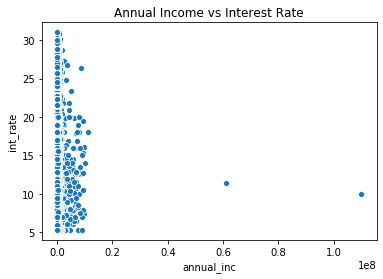

In [20]:
sns.scatterplot(x='annual_inc', y='int_rate', data=loan_df)
plt.title('Annual Income vs Interest Rate')
plt.show()

#### There are two data points that are obvious outliers that we can remove
Remove all rows where annual income is over 10,000,000

In [21]:
loan_df = loan_df.drop(loan_df[loan_df['annual_inc'] > 10000000].index)
loan_df['annual_inc'].describe()

count    1.373225e+06
mean     7.977692e+04
std      8.127545e+04
min      0.000000e+00
25%      4.700000e+04
50%      6.600000e+04
75%      9.500000e+04
max      9.930475e+06
Name: annual_inc, dtype: float64

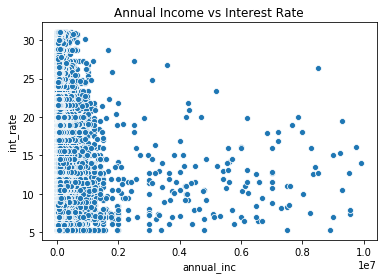

In [22]:
sns.scatterplot(x='annual_inc', y='int_rate', data=loan_df)
plt.title('Annual Income vs Interest Rate')
plt.show()

#### Since Interest rate is going to be our dependent variable lets look at its distribution

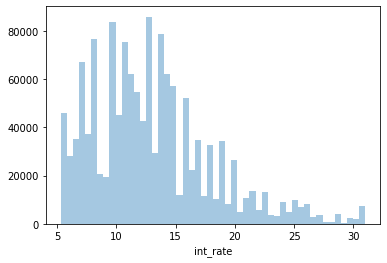

In [23]:
sns.distplot(loan_df['int_rate'],kde = False)
plt.show()

#### Interest Rate above is skewed. Do logarithmic transformation to see if we can get distribution to be less skewed. This can be useful for making patterns in data more interpretable and may improve our R-Squared.

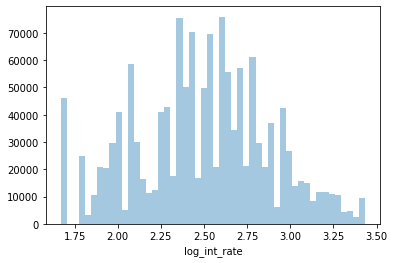

In [24]:
loan_df['log_int_rate'] = loan_df['int_rate'].apply(np.log)

sns.distplot(loan_df['log_int_rate'],kde = False)
plt.show()

# The result is a lot better! Data is less skewed.
# We will be using log_int_rate instead of int_rate as our dependent variable in our regression model

________________________________________________________________

##  <font color=blue>Data Cleaning Part 2: Selecting data with correlation to interest rate</font>
Our list of variables is quite large. We want to narrow it down based on correlation to interest rate. Will also need to create dummy variables for our categorical variables as well

#### Create dummy variables for categorical data

In [25]:
loan_df2 = loan_df.copy()
loan_df2 = pd.get_dummies(loan_df2, columns = ['purpose', 'emp_length', 'disbursement_method', 'term',
                                             'home_ownership', 'application_type']
                        )
loan_df2.head()

,int_rate,loan_amnt,annual_inc,dti,FICO,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,...,disbursement_method_DirectPay,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,application_type_Individual,application_type_Joint App
421095,20.39,5000.0,50000.0,21.80,665.0,0.0,5.0,0.0,116.0,23.2,...,0,1,0,0,0,0,0,1,1,0
421096,9.92,15000.0,196000.0,18.29,700.0,0.0,19.0,0.0,24243.0,46.3,...,0,1,0,0,0,0,1,0,1,0
421097,30.79,11200.0,44000.0,43.97,665.0,2.0,8.0,0.0,1526.0,24.6,...,0,0,1,0,0,0,0,1,0,1
421098,21.85,25000.0,65000.0,12.89,665.0,1.0,7.0,0.0,8657.0,98.4,...,0,0,1,0,1,0,0,0,1,0
421099,7.34,3000.0,52000.0,0.58,760.0,0.0,7.0,0.0,141.0,0.5,...,0,1,0,0,0,0,0,1,1,0


#### Look at the top positive correlation and negative correlation

In [26]:
# Top positive correlation
df_corr = loan_df2.corr()
df_corr = df_corr.sort_values('log_int_rate', ascending=False)

print(df_corr['log_int_rate'].head(25))
# plt.figure(figsize=(10,2))
# df_corr['int_rate'][1:18].plot(kind='bar')
# plt.xticks(rotation=60)
# plt.show()

log_int_rate                  1.000000
int_rate                      0.970715
term_ 60 months               0.344089
bc_util                       0.303525
percent_bc_gt_75              0.289474
revol_util                    0.287399
num_tl_op_past_12m            0.171442
inq_last_12m                  0.168096
disbursement_method_Cash      0.166549
inq_last_6mths                0.165637
open_il_24m                   0.149135
open_il_12m                   0.148895
il_util                       0.142923
open_acc_6m                   0.135835
open_rv_24m                   0.133226
open_rv_12m                   0.123487
dti                           0.121910
purpose_debt_consolidation    0.110238
home_ownership_RENT           0.085398
num_actv_rev_tl               0.083407
pub_rec_bankruptcies          0.068657
num_accts_ever_120_pd         0.066988
pub_rec                       0.065434
loan_amnt                     0.064948
purpose_other                 0.047033
Name: log_int_rate, dtype

In [27]:
# Top negative correlation
print(df_corr['log_int_rate'].tail(20))

# print(df_corr['int_rate'][-12:len(df_corr)])

# plt.figure(figsize = (14,2))
# df_corr['int_rate'][-12:len(df_corr)].plot(kind='bar')
# plt.xticks(rotation=60)
# plt.show()

application_type_Individual     -0.039739
total_acc                       -0.055191
mo_sin_old_il_acct              -0.062497
num_rev_accts                   -0.071537
mths_since_recent_bc            -0.076737
mths_since_rcnt_il              -0.083737
home_ownership_MORTGAGE         -0.084425
annual_inc                      -0.085271
num_bc_tl                       -0.104087
mo_sin_rcnt_tl                  -0.105501
mths_since_recent_inq           -0.121823
mort_acc                        -0.125290
mo_sin_old_rev_tl_op            -0.145718
purpose_credit_card             -0.147144
disbursement_method_DirectPay   -0.166549
total_rev_hi_lim                -0.219435
total_bc_limit                  -0.268447
bc_open_to_buy                  -0.336337
term_ 36 months                 -0.344089
FICO                            -0.463169
Name: log_int_rate, dtype: float64


### Create heatmap to look for multicollinearity

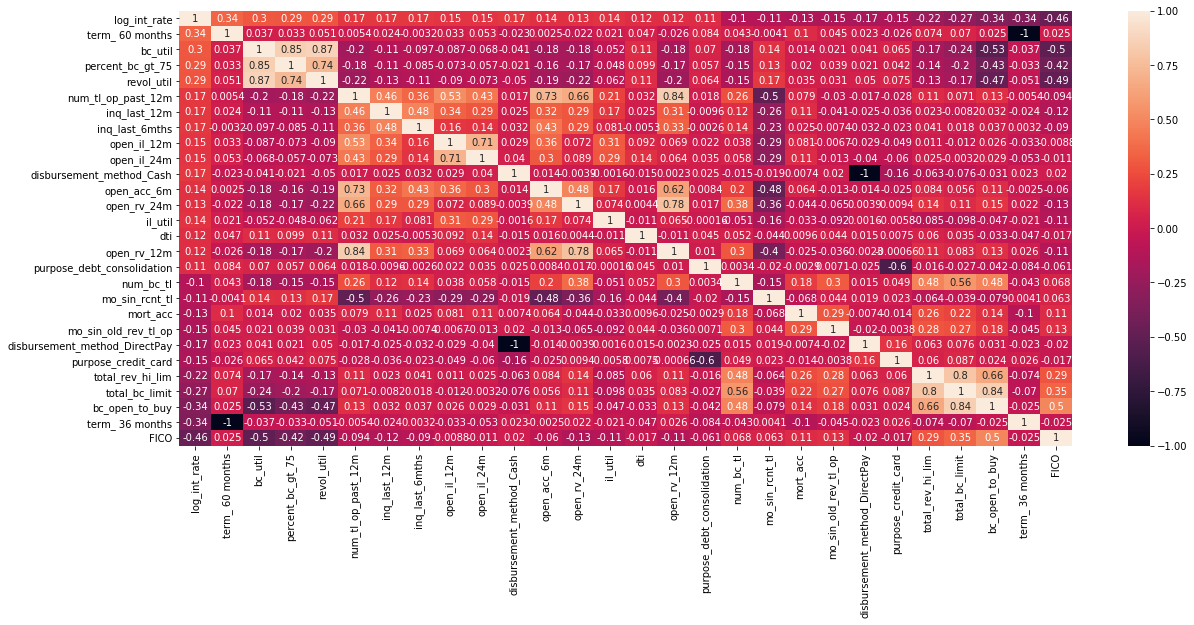

In [28]:
# create a list of variables where correlation coefficients are greater than 0.10 and less than -0.10.
high_corr_list = ['log_int_rate','term_ 60 months', 'bc_util', 'percent_bc_gt_75', 'revol_util',
                  'num_tl_op_past_12m', 'inq_last_12m', 'inq_last_6mths', 'open_il_12m', 'open_il_24m', 
                  'disbursement_method_Cash', 'open_acc_6m', 'open_rv_24m', 'il_util', 'dti', 'open_rv_12m',                 
                  'purpose_debt_consolidation', 'num_bc_tl',
                  'mo_sin_rcnt_tl', 'mort_acc', 'mo_sin_old_rev_tl_op', 'disbursement_method_DirectPay',
                  'purpose_credit_card',  'total_rev_hi_lim',  
                  'total_bc_limit',  'bc_open_to_buy', 'term_ 36 months', 'FICO']                      
                                     
                  
plt.figure(figsize=(20,8))
sns.heatmap(loan_df2[high_corr_list].corr(), annot=True, fmt = '.2g')
plt.show()                   

### Get rid of variables that display multicollinearity, variables that are redundant and variables with the weakest correlation
I also removed redundant variables based on the definition of each variable given in the dataset's dictionary. The variables in corr_list_test will be used in the regression model as well due to moderately strong correlation to interest rate.

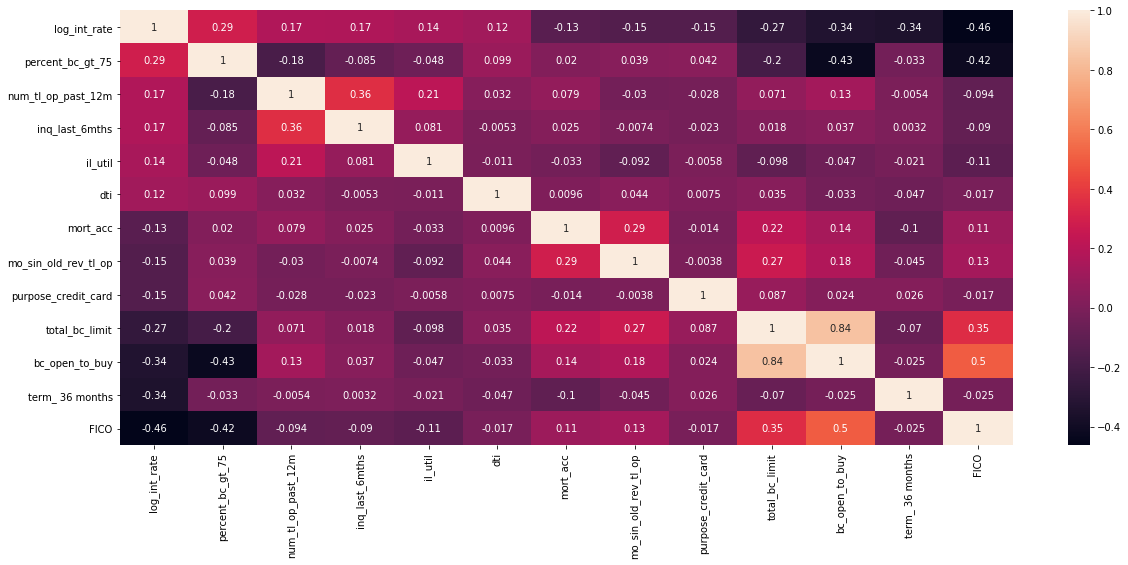

In [29]:
corr_list_test = ['log_int_rate', 'percent_bc_gt_75',
                  'num_tl_op_past_12m', 'inq_last_6mths', 
                  'il_util', 'dti', 'mort_acc', 'mo_sin_old_rev_tl_op',
                  'purpose_credit_card', 'total_bc_limit', 'bc_open_to_buy', 'term_ 36 months', 'FICO']

plt.figure(figsize=(20,8))
sns.heatmap(loan_df2[corr_list_test].corr(), annot=True, fmt = '.2g')
plt.show()            

### Top variables that are correlated to adjusted interest rate

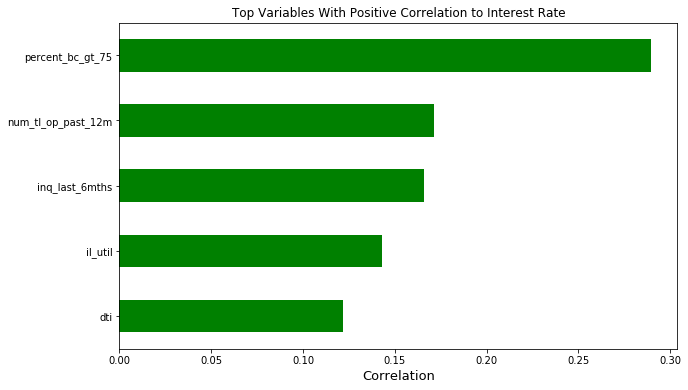

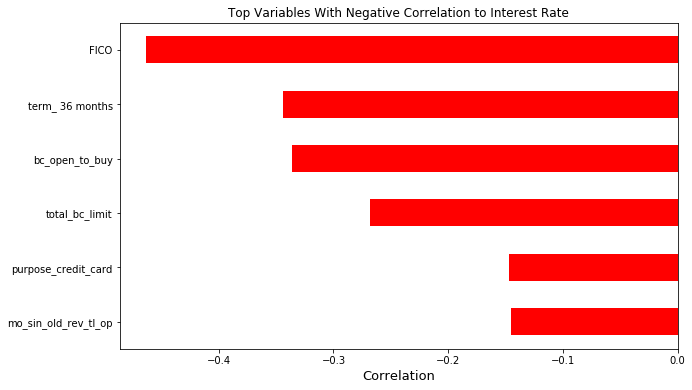

In [30]:
# For positive correlation
pos_corr_list = ['percent_bc_gt_75', 'num_tl_op_past_12m', 'inq_last_6mths', 'il_util', 'dti']

plt.figure(figsize=(10,6))
df_corr['log_int_rate'][pos_corr_list].sort_values(ascending=True).plot(kind='barh', color='green')
plt.xticks(rotation=0)
plt.xlabel("Correlation", fontsize=13)
plt.title("Top Variables With Positive Correlation to Interest Rate")
plt.show()


# For negative correlation
neg_corr_list = ['mo_sin_old_rev_tl_op', 'purpose_credit_card', 
                  'total_bc_limit', 'bc_open_to_buy', 'term_ 36 months', 'FICO']

plt.figure(figsize=(10,6))
df_corr['log_int_rate'][neg_corr_list].plot(kind='barh', color='red')
plt.xticks(rotation=0)
plt.xlabel("Correlation", fontsize=13)
plt.title("Top Variables With Negative Correlation to Interest Rate")
plt.show()

##  <font color=blue>Insights</font>

#### Problem 1: 
We are looking for ways to improve customer service for those who received an offer they did not like due to high interest rate.

#### Problem 2: 
Customers that are unhappy with their offer may lead to a bad customer experience if they do not know why they received the rate that they did. Bad customer experience may lead them to apply to other lenders if they are searching for a lower rate. We want to improve their experience so that they will want to re-apply with us in the future (whether it is a first time customer or a current customer looking to refinance their loan.

#### Problem 3: 
This is a competitive market where there are many lenders. We want to be able to maintain our share of the market.

#### Summary:
This project will look at variables correlated to loan interest rate. In order to improve customer experience for customers who received offers they did not like, due to high interest rate, we need to know what affects their interest rate. By knowing what affects their rate, we can have our sales rep advise our customers on areas they can improve on so that they can re-apply in the future for a lower rate if they choose to. We hope this would improve overall customer experience and may save time/money trying to aqcuire new customers. 

______________________________________________________________________________________________________

### What we expected going into this dataset
Besides from FICO score, we expected having a joint applicant, years of employment, annual income, owning a mortgage, and loan amount to be the top variables linked to interest rate, but that was not the case in this dataset.

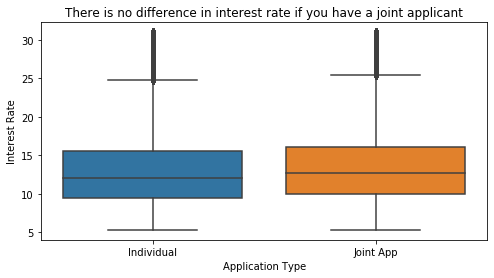

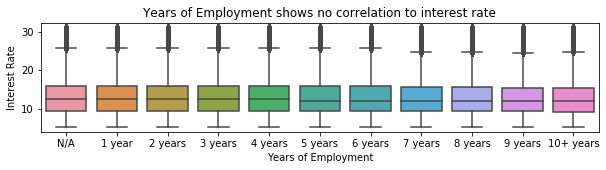

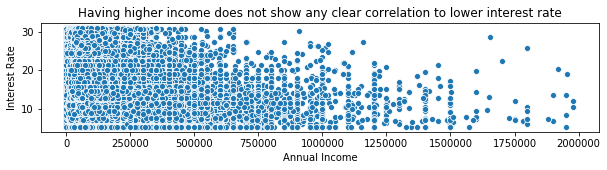

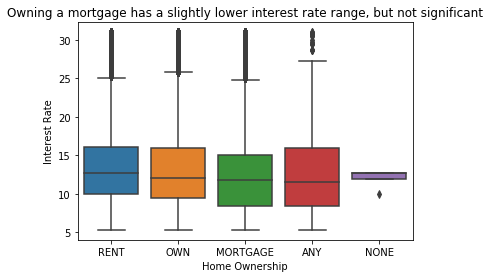

In [31]:
# Individual/Joint application type vs Interest Rate
plt.figure(figsize=(8,4))
sns.boxplot(x='application_type', y= 'int_rate', data = loan_df)
plt.title('There is no difference in interest rate if you have a joint applicant')
plt.ylabel("Interest Rate")
plt.xlabel("Application Type")
plt.show()

print("")

# Years of Employment vs Interest Rate
order = ['N/A','1 year', '2 years', '3 years', '4 years',
       '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
plt.figure(figsize=(10,2))
sns.boxplot(x='emp_length', y='int_rate', data=loan_df, order=order)
plt.title('Years of Employment shows no correlation to interest rate')
plt.ylabel("Interest Rate")
plt.xlabel("Years of Employment")
plt.show()

print("")

# Annual Income vs Interest Rate
plt.figure(figsize=(10,2))
sns.scatterplot(x='annual_inc', y= 'int_rate', data = loan_df[loan_df['annual_inc']<2000000])
plt.title('Having higher income does not show any clear correlation to lower interest rate')
plt.ylabel("Interest Rate")
plt.xlabel("Annual Income")
plt.show()

print("")

# Home ownership vs Interest Rate
plt.figure(figsize=(6,4))
sns.boxplot(x='home_ownership', y='int_rate', data=loan_df)
plt.title('Owning a mortgage has a slightly lower interest rate range, but not significant')
plt.ylabel("Interest Rate")
plt.xlabel("Home Ownership")
plt.show()

____________________________________________________________________________________

### Top Variables with Positive Correlation to Interest Rate
1. <font color=blue>percent_bc_gt_75</font> (Percent of all credit cards greater than 75% of credit limit)
2. <font color=blue>num_tl_op_past_12m</font> (Total number of accounts opened in the last 12 months)
3. <font color=blue>inq_last_6mths</font> (Total number of inquiries in the last 6 months)
4. <font color=blue>il_util</font> (Ratio of total current balance to credit limit on all installment accounts)
5. <font color=blue>dti</font> (Total monthly debt payments, excluding mortgage, divided by monthly income)

*** To view correlation bar chart please scroll up!***

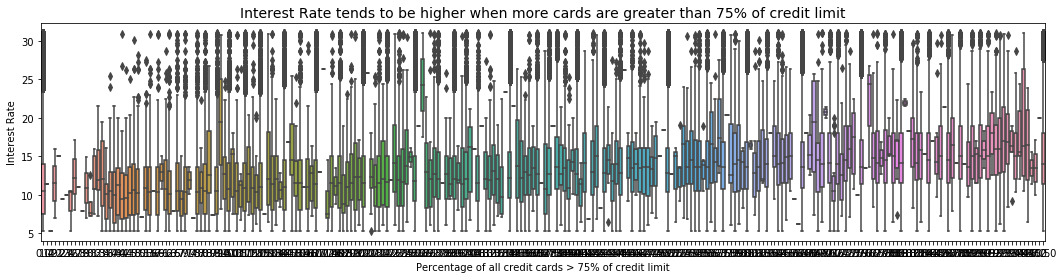

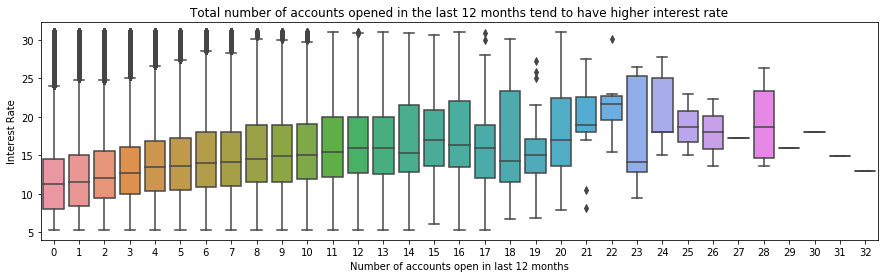

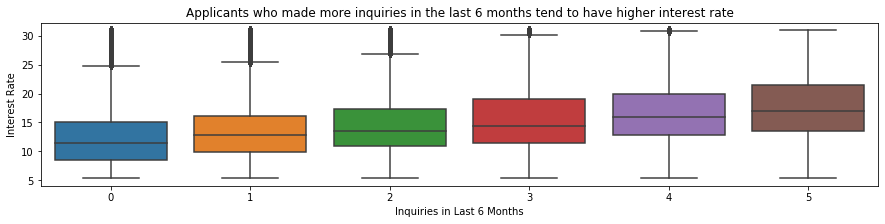

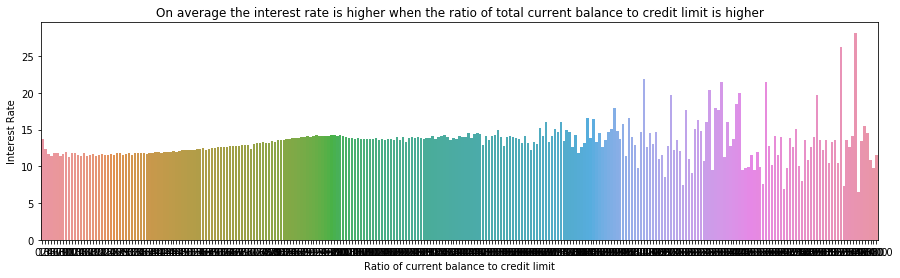

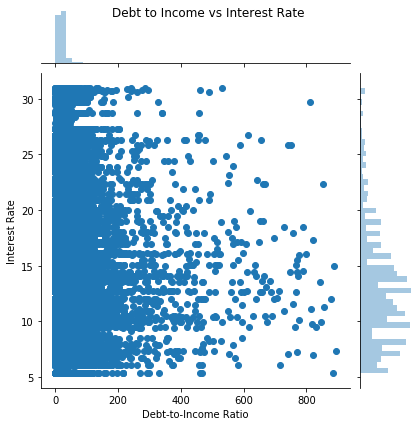

In [32]:
# Percent of all credit cards greater than 75% of credit limit
plt.figure(figsize=(18,4))
sns.boxplot(x='percent_bc_gt_75',y='int_rate', data=loan_df)
plt.title("Interest Rate tends to be higher when more cards are greater than 75% of credit limit", fontsize=14)
plt.xlabel("Percentage of all credit cards > 75% of credit limit")
plt.ylabel("Interest Rate")
plt.show()

print("")

# Change data type to integer so that the x-axis will not be so cluttered
loan_df['num_tl_op_past_12m'] = loan_df["num_tl_op_past_12m"].astype(int)

# Total accounts opened in the last 12 months. Includes installment and revolving accounts.
plt.figure(figsize=(15,4))
sns.boxplot(x='num_tl_op_past_12m', y='int_rate', data=loan_df)
plt.title("Total number of accounts opened in the last 12 months tend to have higher interest rate")
plt.xlabel("Number of accounts open in last 12 months")
plt.ylabel("Interest Rate")
plt.show()


print("")

# Total inquiries in the last 6 months
loan_df['inq_last_6mths'] = loan_df['inq_last_6mths'].astype(int)
                                                        
plt.figure(figsize=(15,3))
sns.boxplot(x='inq_last_6mths', y='int_rate', data=loan_df)
plt.title("Applicants who made more inquiries in the last 6 months tend to have higher interest rate")
plt.ylabel("Interest Rate")
plt.xlabel("Inquiries in Last 6 Months")
plt.show()

print("")

# Ratio of total current balance to credit limit on all installment acct
plt.figure(figsize=(15,4))
sns.barplot(x='il_util', y='int_rate', data=loan_df, ci=None)
plt.xlabel("Ratio of current balance to credit limit")
plt.ylabel("Interest Rate")
plt.title("On average the interest rate is higher when the ratio of total current balance to credit limit is higher")
plt.show()

print("")

# Debt to Income vs Interest Rate
sns.jointplot(x='dti',y='int_rate', data=loan_df[loan_df['dti']<900]).set_axis_labels("Debt-to-Income Ratio","Interest Rate")
plt.suptitle("Debt to Income vs Interest Rate")
plt.show()


____________________________________________________________________________________________________________________

### Top Variables with Negative Correlation to Interest Rate
1. <font color=blue>FICO</font> (Having a good FICO score)
2. <font color=blue>term_36 months</font> (Choosing a 36 months term loan opposed to 60 months)
3. <font color=blue>bc_open_to_buy</font> (Total credit available on all revolving credit cards)
4. <font color=blue>total_bc_limit</font> (Total limit on all credit cards)
5. <font color=blue>purpose_credit_card</font> (Purpose of loan is to pay off credit cards)

*** To view correlation bar chart please scroll up!***

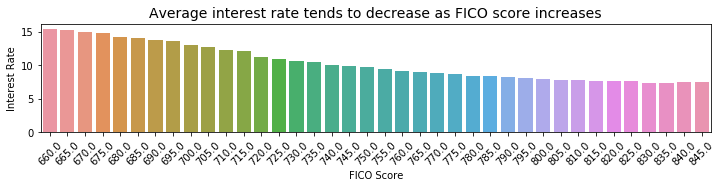

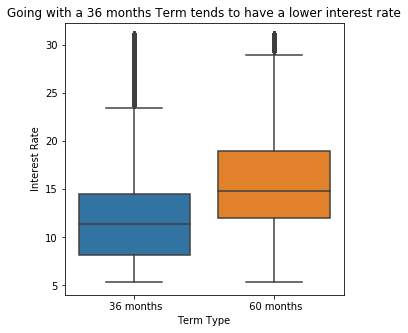

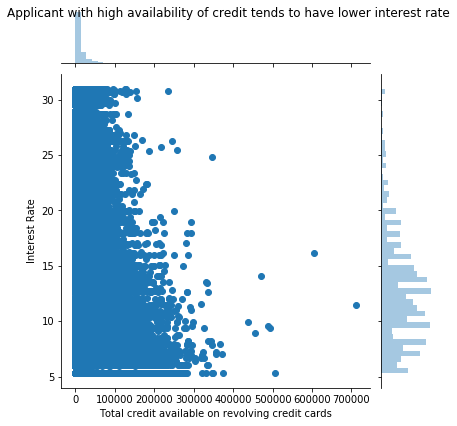

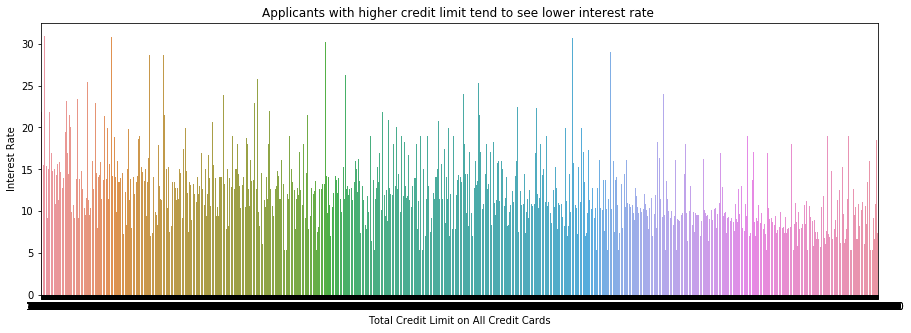

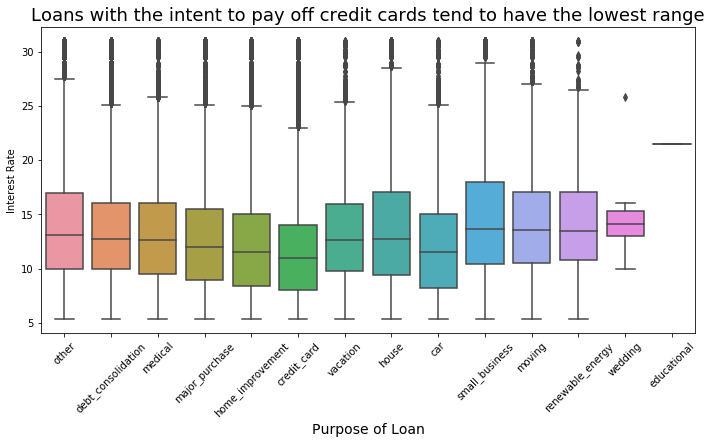

In [33]:
# FICO Score vs Interest Rate
plt.figure(figsize=(12,2))
sns.barplot(x ='FICO', y ='int_rate', data = loan_df, ci=None)
plt.xlabel('FICO Score')
plt.ylabel('Interest Rate')
plt.xticks(rotation=45)
plt.title('Average interest rate tends to decrease as FICO score increases', fontsize=14)
plt.show()

print("")

# Term Type vs Interest Rate
plt.figure(figsize=(5,5))
sns.boxplot(x='term', y= 'int_rate', data = loan_df)
plt.title('Going with a 36 months Term tends to have a lower interest rate')
plt.ylabel("Interest Rate")
plt.xlabel("Term Type")
plt.show()

print("")

# Total credit available on all credit cards vs Interest Rate
sns.jointplot(x='bc_open_to_buy', y='int_rate', data=loan_df).set_axis_labels("Total credit available on revolving credit cards", "Interest Rate")
plt.suptitle('Applicant with high availability of credit tends to have lower interest rate')
plt.show()

print("")

# Total credit limit vs Interest Rate
plt.figure(figsize=(15,5))
sns.barplot(x='total_bc_limit', y='int_rate', data=loan_df, ci=None)
plt.title("Applicants with higher credit limit tend to see lower interest rate ")
plt.xlabel("Total Credit Limit on All Credit Cards")
plt.ylabel("Interest Rate")
plt.show()

print("")

# Purpose of loan
plt.figure(figsize=(10,5))
sns.boxplot(x='purpose', y ='int_rate', data=loan_df)
plt.tight_layout()
plt.title("Loans with the intent to pay off credit cards tend to have the lowest range", fontsize=18)
plt.ylabel("Interest Rate")
plt.xlabel("Purpose of Loan", fontsize=14)
plt.xticks(rotation=45)
plt.show()



________________________________________________________________________________________________________

### Variables that showed weak correlation to interest rate
1. mort_acc (Number of mortgages)
2. mo_sin_old_rev_tl_op (Months since oldest account opened)

*** To view correlation bar chart please scroll up!***

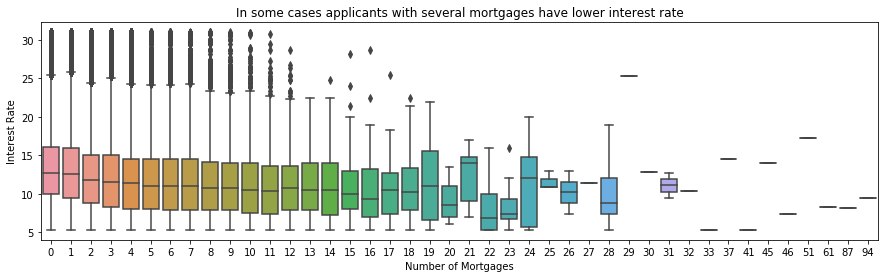

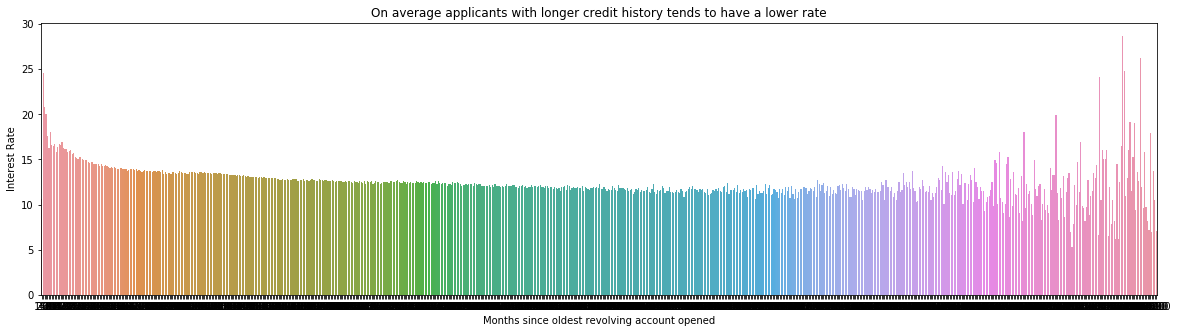

In [34]:
# Number of mortgage accounts
loan_df['mort_acc'] = loan_df["mort_acc"].astype(int)
plt.figure(figsize=(15,4))
sns.boxplot(x='mort_acc', y='int_rate', data=loan_df)
plt.xlabel("Number of Mortgages")
plt.ylabel("Interest Rate")
plt.title("In some cases applicants with several mortgages have lower interest rate")
plt.show()

print("")

# Months since oldest revolving account opened
plt.figure(figsize=(20,5))
sns.barplot(x='mo_sin_old_rev_tl_op', y='int_rate', data=loan_df, ci=None)
plt.xlabel("Months since oldest revolving account opened")
plt.ylabel("Interest Rate")
plt.title("On average applicants with longer credit history tends to have a lower rate")
plt.show()

_________________________________________________________________________________________________________________

### Their is no significant correlation between state and interest rate. It is about the same across each state. NH and DC have a slightly lower range but not significantly lower

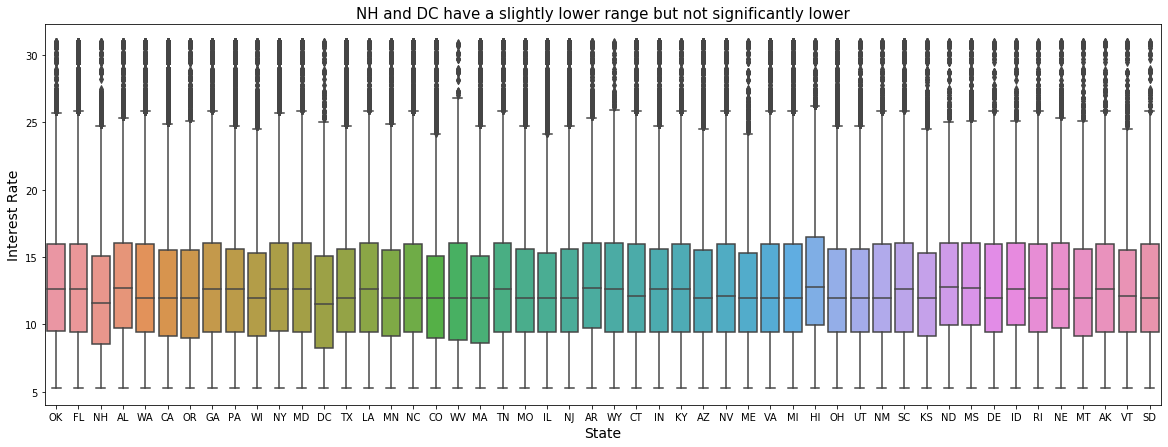

In [35]:
plt.figure(figsize=(20,7))
sns.boxplot(x='addr_state', y='int_rate', data=loan_df)

plt.title("NH and DC have a slightly lower range but not significantly lower",
         fontsize=15)
plt.ylabel("Interest Rate", fontsize=14)
plt.xlabel("State", fontsize=14)
plt.show()

__________________________________________________________________________________________

### Variables excluded even though there were strong correlation to interest rate

Should not include disbursement method because there isn't enough data to prove that direct pay will lead to lower interest rate. Also, it does not make sense why it would affect interest rate.

We do not want to use grade as a variable in our regression model because the grade of the loan basically defines the interest rate. That is similar to having interest rate as an independent variable to predict the interest rate. For this reason we are going to exclude grade. We cannot go to the customers and tell them that their offer was mostly determined by a grade. That information would not help them. What we should do is try to figure out how the grade is calculated.

Cash         1295103
DirectPay      78122
Name: disbursement_method, dtype: int64


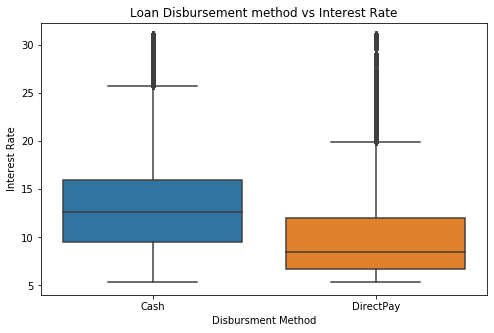

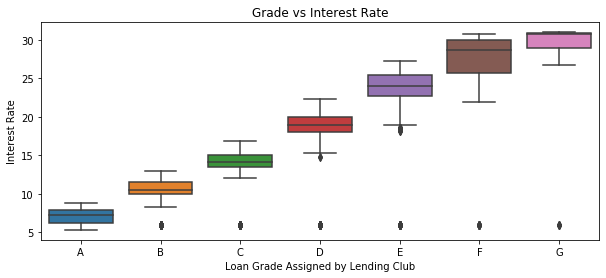

In [39]:
print(loan_df['disbursement_method'].value_counts())
plt.figure(figsize=(8,5))
sns.boxplot(x='disbursement_method', y ='int_rate', data=loan_df)
plt.title('Loan Disbursement method vs Interest Rate')
plt.xlabel('Disbursment Method')
plt.ylabel('Interest Rate')
plt.show()

print("")

# Grade vs Interest Rate
grade_order = ['A','B','C','D','E','F','G']
plt.figure(figsize=(10,4))
sns.boxplot(x='grade', y='int_rate', data=loan_df, order=grade_order)
plt.title('Grade vs Interest Rate')
plt.xlabel("Loan Grade Assigned by Lending Club")
plt.ylabel("Interest Rate")
plt.show()


# <font color=blue>Insights Part II: Regression</font>

In [37]:
# The variables below are chosen for the regression model due to strong - moderate correlation to interest rate

x_vars = ['percent_bc_gt_75', 'num_tl_op_past_12m', 'inq_last_6mths', 
          'il_util', 'dti', 'mort_acc', 'mo_sin_old_rev_tl_op', 'purpose_credit_card', 
          'total_bc_limit', 'bc_open_to_buy', 'term_ 36 months', 'FICO']

y_data = loan_df2['log_int_rate']
x_data = loan_df2[x_vars] 
x_data = sm.add_constant(x_data)

model = sm.OLS(y_data,x_data).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_int_rate   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 9.265e+04
Date:                Mon, 27 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:57:29   Log-Likelihood:            -2.4097e+05
No. Observations:             1373225   AIC:                         4.820e+05
Df Residuals:                 1373212   BIC:                         4.821e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.0926      0.007    781.679      0.000       5.080       5.105
percent_bc_gt_75         0.0016   8.49e-06    184.561      0.000       0.002       0.002
num_tl_op_past_12m       0.0266      0.000    180.224      0.000       0.026       0.027
inq_last_6mths           0.0503      0.000    151.285      0.000       0.050       0.051
il_util                  0.0010   1.16e-05     82.493      0.000       0.001       0.001
dti                      0.0020   1.48e-05    135.323      0.000       0.002       0.002
mort_acc                -0.0229      0.000   -154.152      0.000      -0.023      -0.023
mo_sin_old_rev_tl_op    -0.0002   2.68e-06    -93.053      0.000      -0.000      -0.000
purpose_credit_card     -0.1288      0.001   -216.732      0.000      -0.130      -0.128
total_bc_limit       -8.899e-07   2.12e-08    -41.979      0.000   -9.31e-07   -8.48e-07
bc_open_to_buy       -1.455e-06   3.16e-08    -46.051      0.000   -1.52e-06   -1.39e-06
term_ 36 months         -0.3086      0.001   -557.144      0.000      -0.310      -0.308
FICO                    -0.0035   8.98e-06   -393.543      0.000      -0.004      -0.004
==============================================================================
Omnibus:                    13677.564   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15435.136
Skew:                           0.202   Prob(JB):                         0.00
Kurtosis:                       3.328   Cond. No.                     1.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
model_prediction = model.predict(x_data)
model_prediction.reset_index(inplace=True, drop=True)
model_prediction.head()

0    2.547697
1    2.469821
2    3.033938
3    2.972312
4    1.967492
dtype: float64

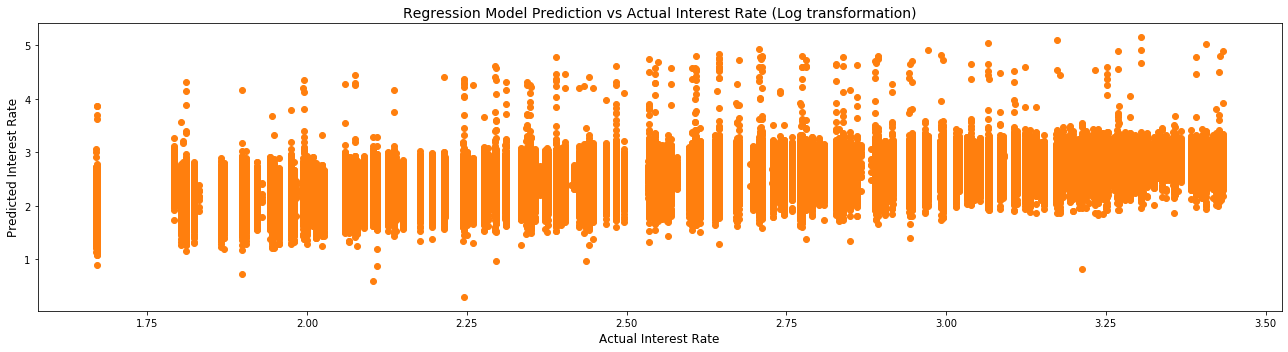

In [77]:
fig, axes = plt.subplots(figsize =(18,5))
ax1 = axes
color = 'tab:orange'
ax1.scatter(loan_df['log_int_rate'], model_prediction, color= color)
plt.ylabel("Predicted Interest Rate", fontsize =12)
plt.xlabel("Actual Interest Rate", fontsize=12)
plt.title("Regression Model Prediction vs Actual Interest Rate (Log transformation)", fontsize=14)
fig.tight_layout()
plt.show()



TypeError: expected 1D vector for x

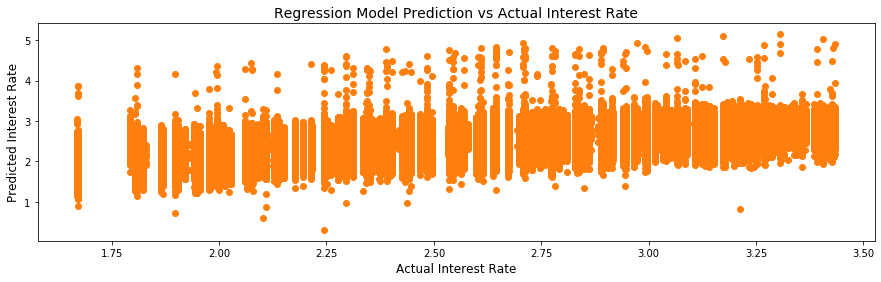

In [79]:
plt.figure(figsize=(15,4))
color = 'tab:orange'
plt.scatter(loan_df['log_int_rate'], model_prediction, color= color)
plt.ylabel("Predicted Interest Rate", fontsize =12)
plt.xlabel("Actual Interest Rate", fontsize=12)
plt.title("Regression Model Prediction vs Actual Interest Rate", fontsize=14)
fig.tight_layout()

plt.show()


### Conclusion:
From the Lending Club dataset, we narrowed down the dataset to 12 variables and an R-Squared of 0.447

Customers that are approved for a loan but do not like their rate can work on the 12 variables mentioned below and re-apply a few months later to see if they will receive a better rate. Although the regression model is not great, we hope that this can still provide insights for the sales team so that they can help improve customer experience even when they received a rate they did not like by providing advice on how they can lower their rate. Improving customer experience for applicants that did not take an offer due to high interest rate may help save time/money trying to acquire new customers because they may work on areas advised by our sales team and re-apply in the future.

The advice being given should be sound advice catered to each applicant. For example, we should not be telling applicants to get more mortgages because that will reduce their interest rate... If the applicant happens to have a mortgage or 2 it is good to inform them that because they have a few mortgages it helped lower their rate.  So is this model useless? Not entirely, because we identitfied a few variables that have moderate to strong correlation to interest rate, but this model could be improved.  

#### To improve this model:
1. More data may be required that may not have been available
2. A more advance method of analysis may be required 
3. A more complex model than a regression model (Random Forest Regressor, Decision Tree Regressor)


#### The following are the top variables that will increase the applicant's interest rate:
1. <font color=blue>percent_bc_gt_75</font> (Percent of all credit cards greater than 75% of credit limit)
2. <font color=blue>num_tl_op_past_12m</font> (Total number of accounts opened in the last 12 months)
3. <font color=blue>inq_last_6mths</font> (Total number of inquiries in the last 6 months)
4. <font color=blue>il_util</font> (Ratio of total current balance to credit limit on all installment accounts)
5. <font color=blue>dti</font> (Total monthly debt payments, excluding mortgage, divided by monthly income)



#### The following are the top variables that will decrease the applicant's interest rate:
1. <font color=blue>FICO</font> (Having a good FICO score)
2. <font color=blue>term_36 months</font> (Choosing a 36 months term loan opposed to 60 months)
3. <font color=blue>bc_open_to_buy</font> (Total credit available on all revolving credit cards)
4. <font color=blue>total_bc_limit</font> (Total limit on all credit cards)
5. <font color=blue>purpose_credit_card</font> (purpose of loan is to pay off credit cards)
6. <font color=blue>mo_sin_old_rev_tl_op</font> (Months since oldest revolving account opened)
7. <font color=blue>mort_acc</font> (Number of mortgage accounts)


In [38]:
#loan_df.to_csv("LC_capstone2.csv")